In [1]:
# Import libraries and modules
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

2023-09-14 15:22:27.663305: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-14 15:22:27.687462: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 15:22:27.869214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-14 15:22:27.871080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 15:22:29.639793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
# Data and Image Processing
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test/test')

print(train_dir, valid_dir, test_dir)

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(valid_dir)])
total_test = len(os.listdir(test_dir))

print("Total number of train files is:", total_train, "\nTotal number of val files is:", total_val, "\nTotal number of test files is:", total_test)

# Variables for pre-processing and training.
batch_size = 32
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

cats_and_dogs/train cats_and_dogs/validation cats_and_dogs/test/test
Total number of train files is: 2001 
Total number of val files is: 1001 
Total number of test files is: 51


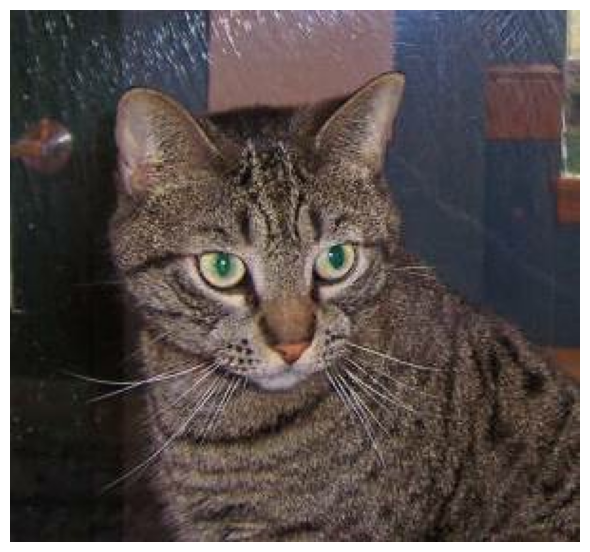

In [4]:
# Cat Image Visualization
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = 'cats_and_dogs/train/cats/cat.1.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show()

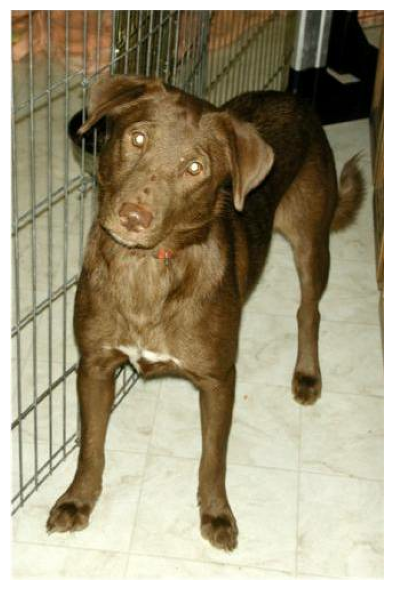

In [5]:
# Dog Image Visualization
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = 'cats_and_dogs/train/dogs/dog.1.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show()

In [6]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1.0/255
)

valid_image_generator = ImageDataGenerator(
    rescale=1.0 / 255
)

test_image_generator = ImageDataGenerator(
    rescale=1.0 / 255
)

In [7]:
# 6


train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')


valid_data_gen = valid_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=valid_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')


test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory='./cats_and_dogs/test',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode=None)

import os

print("Current working directory:", os.getcwd())



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
Current working directory: /home/michels/Dog-Cat-Image-Classifier


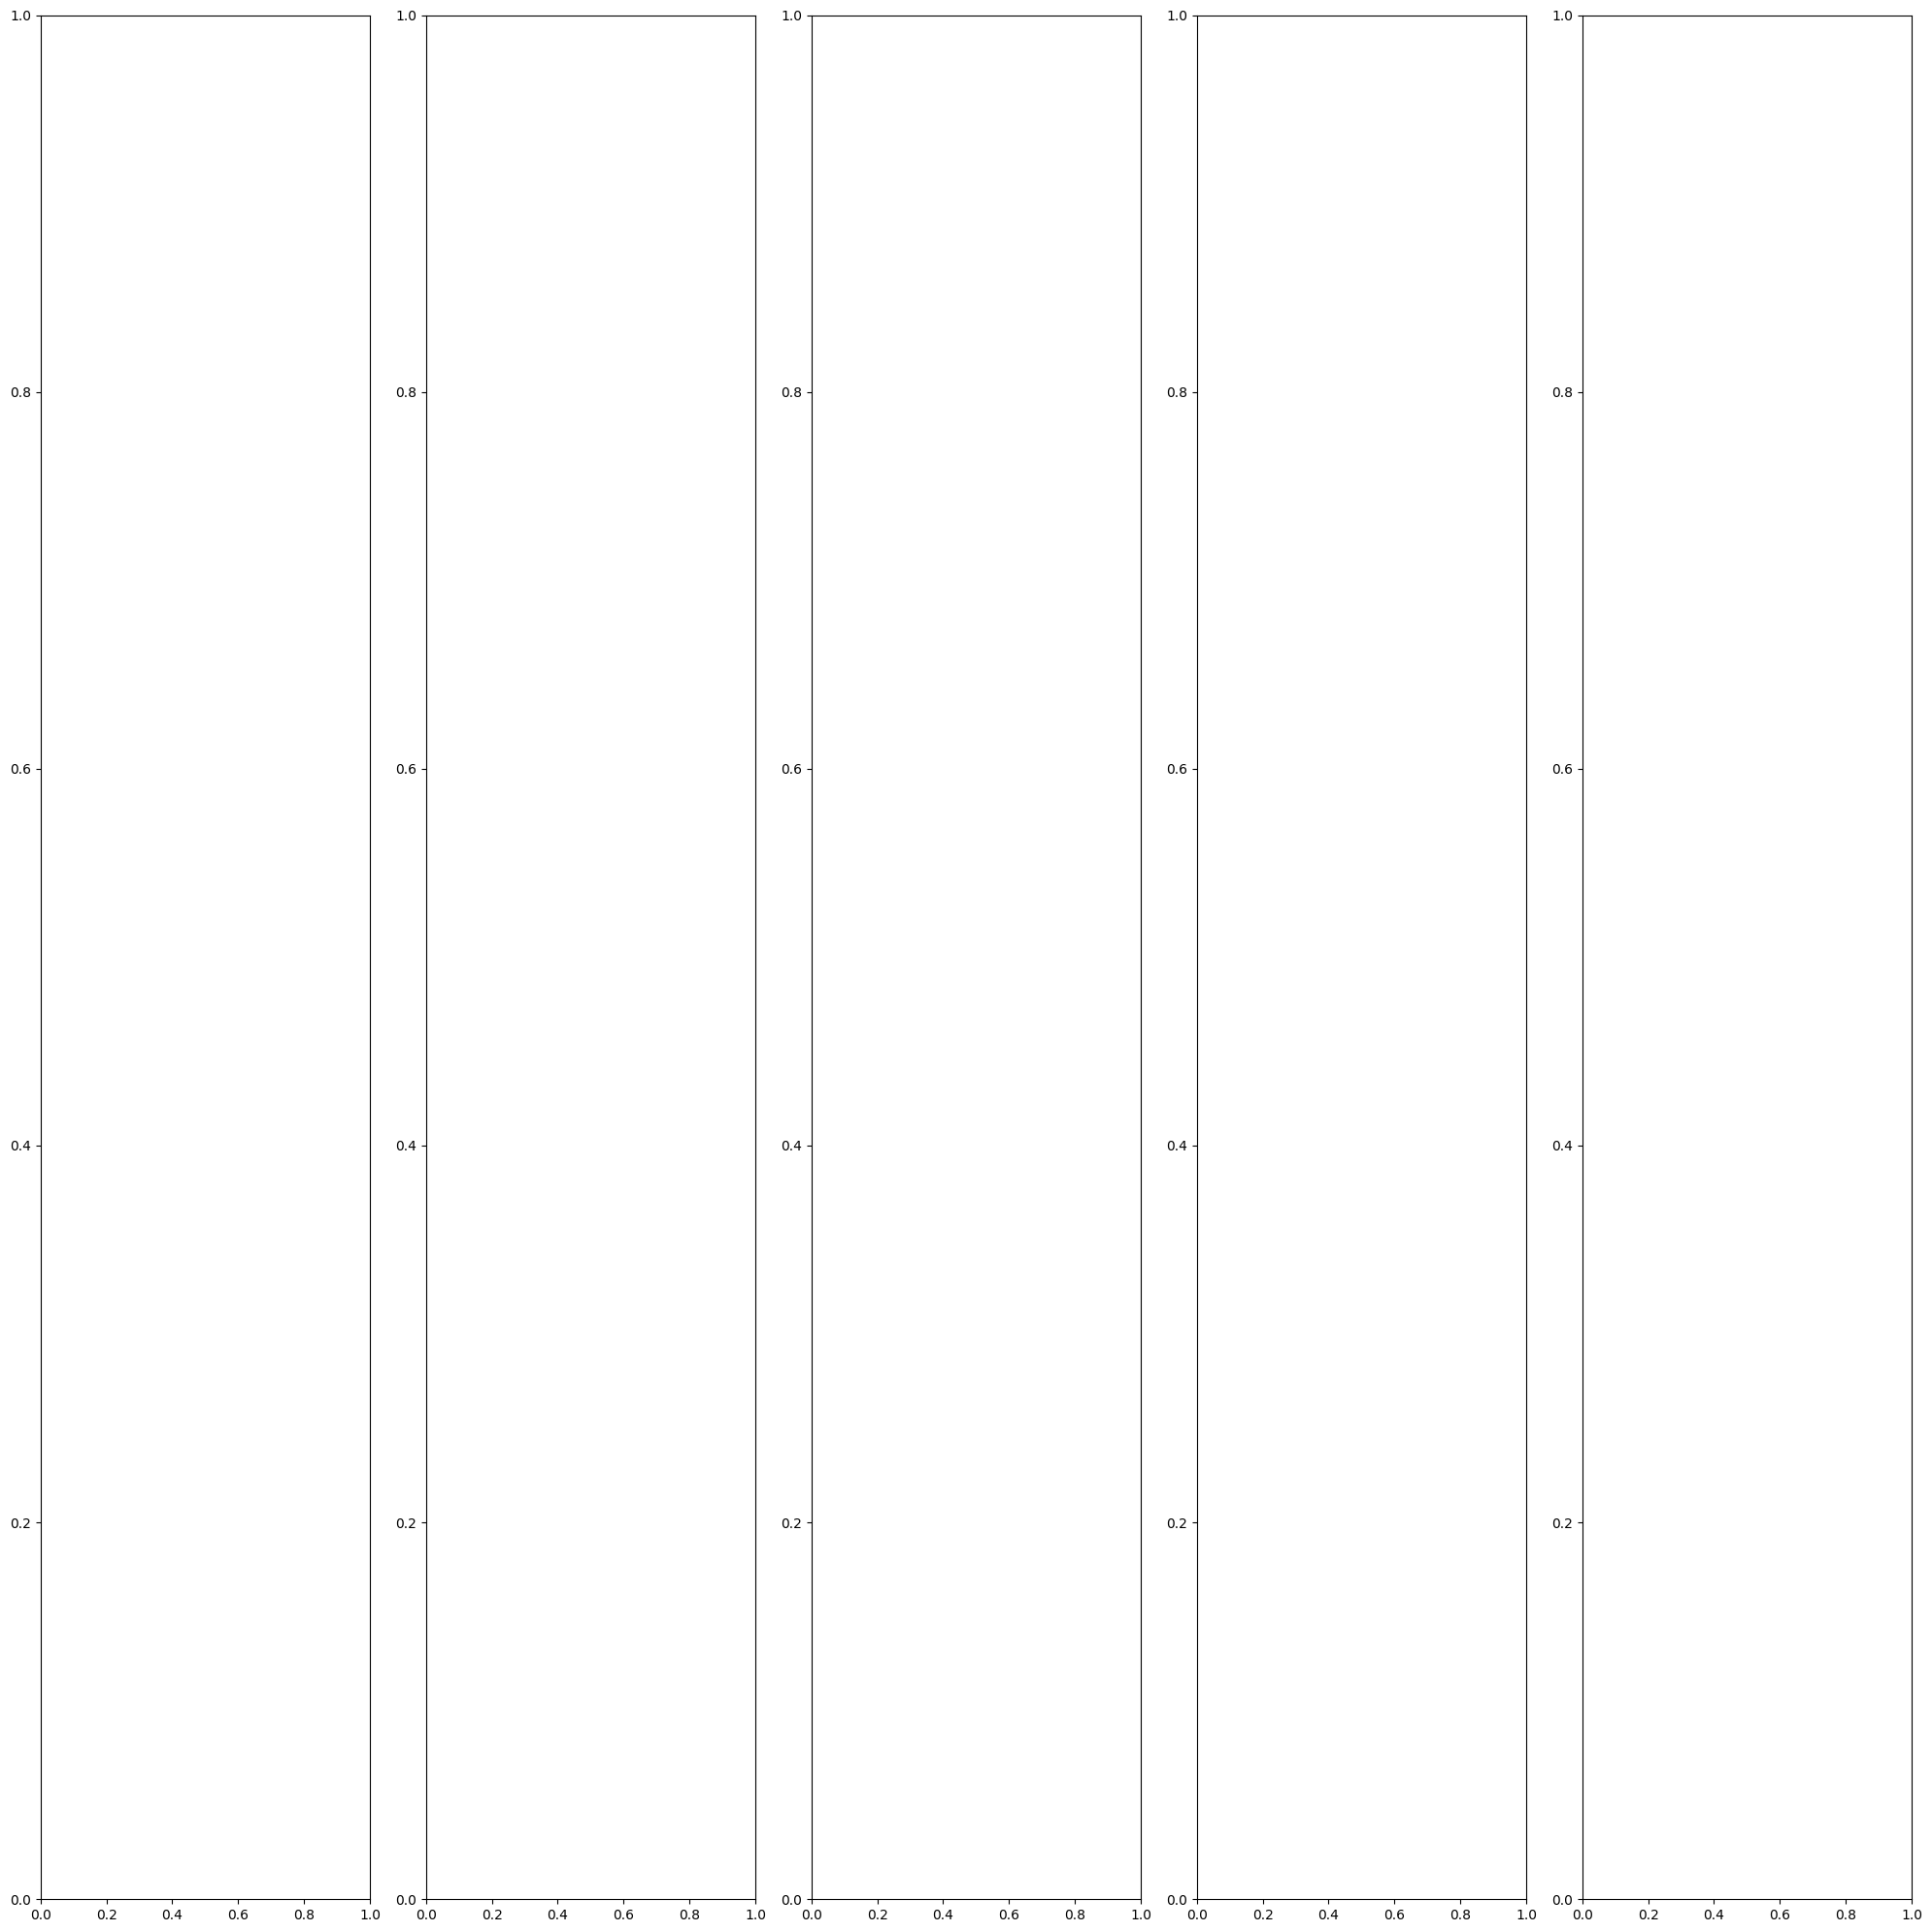

In [8]:

def plot_images(images_arr, probabilities = []):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for image, ax, (index, prob) in zip(images_arr, axes, enumerate(probabilities)):
        ax.imshow(image)
        ax.axis("off")
        if probabilities:
            ax.set_title(f'{100*prob:2f}% dog')
    plt.tight_layout()
    plt.show()


sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[:5])

Found 2000 images belonging to 2 classes.


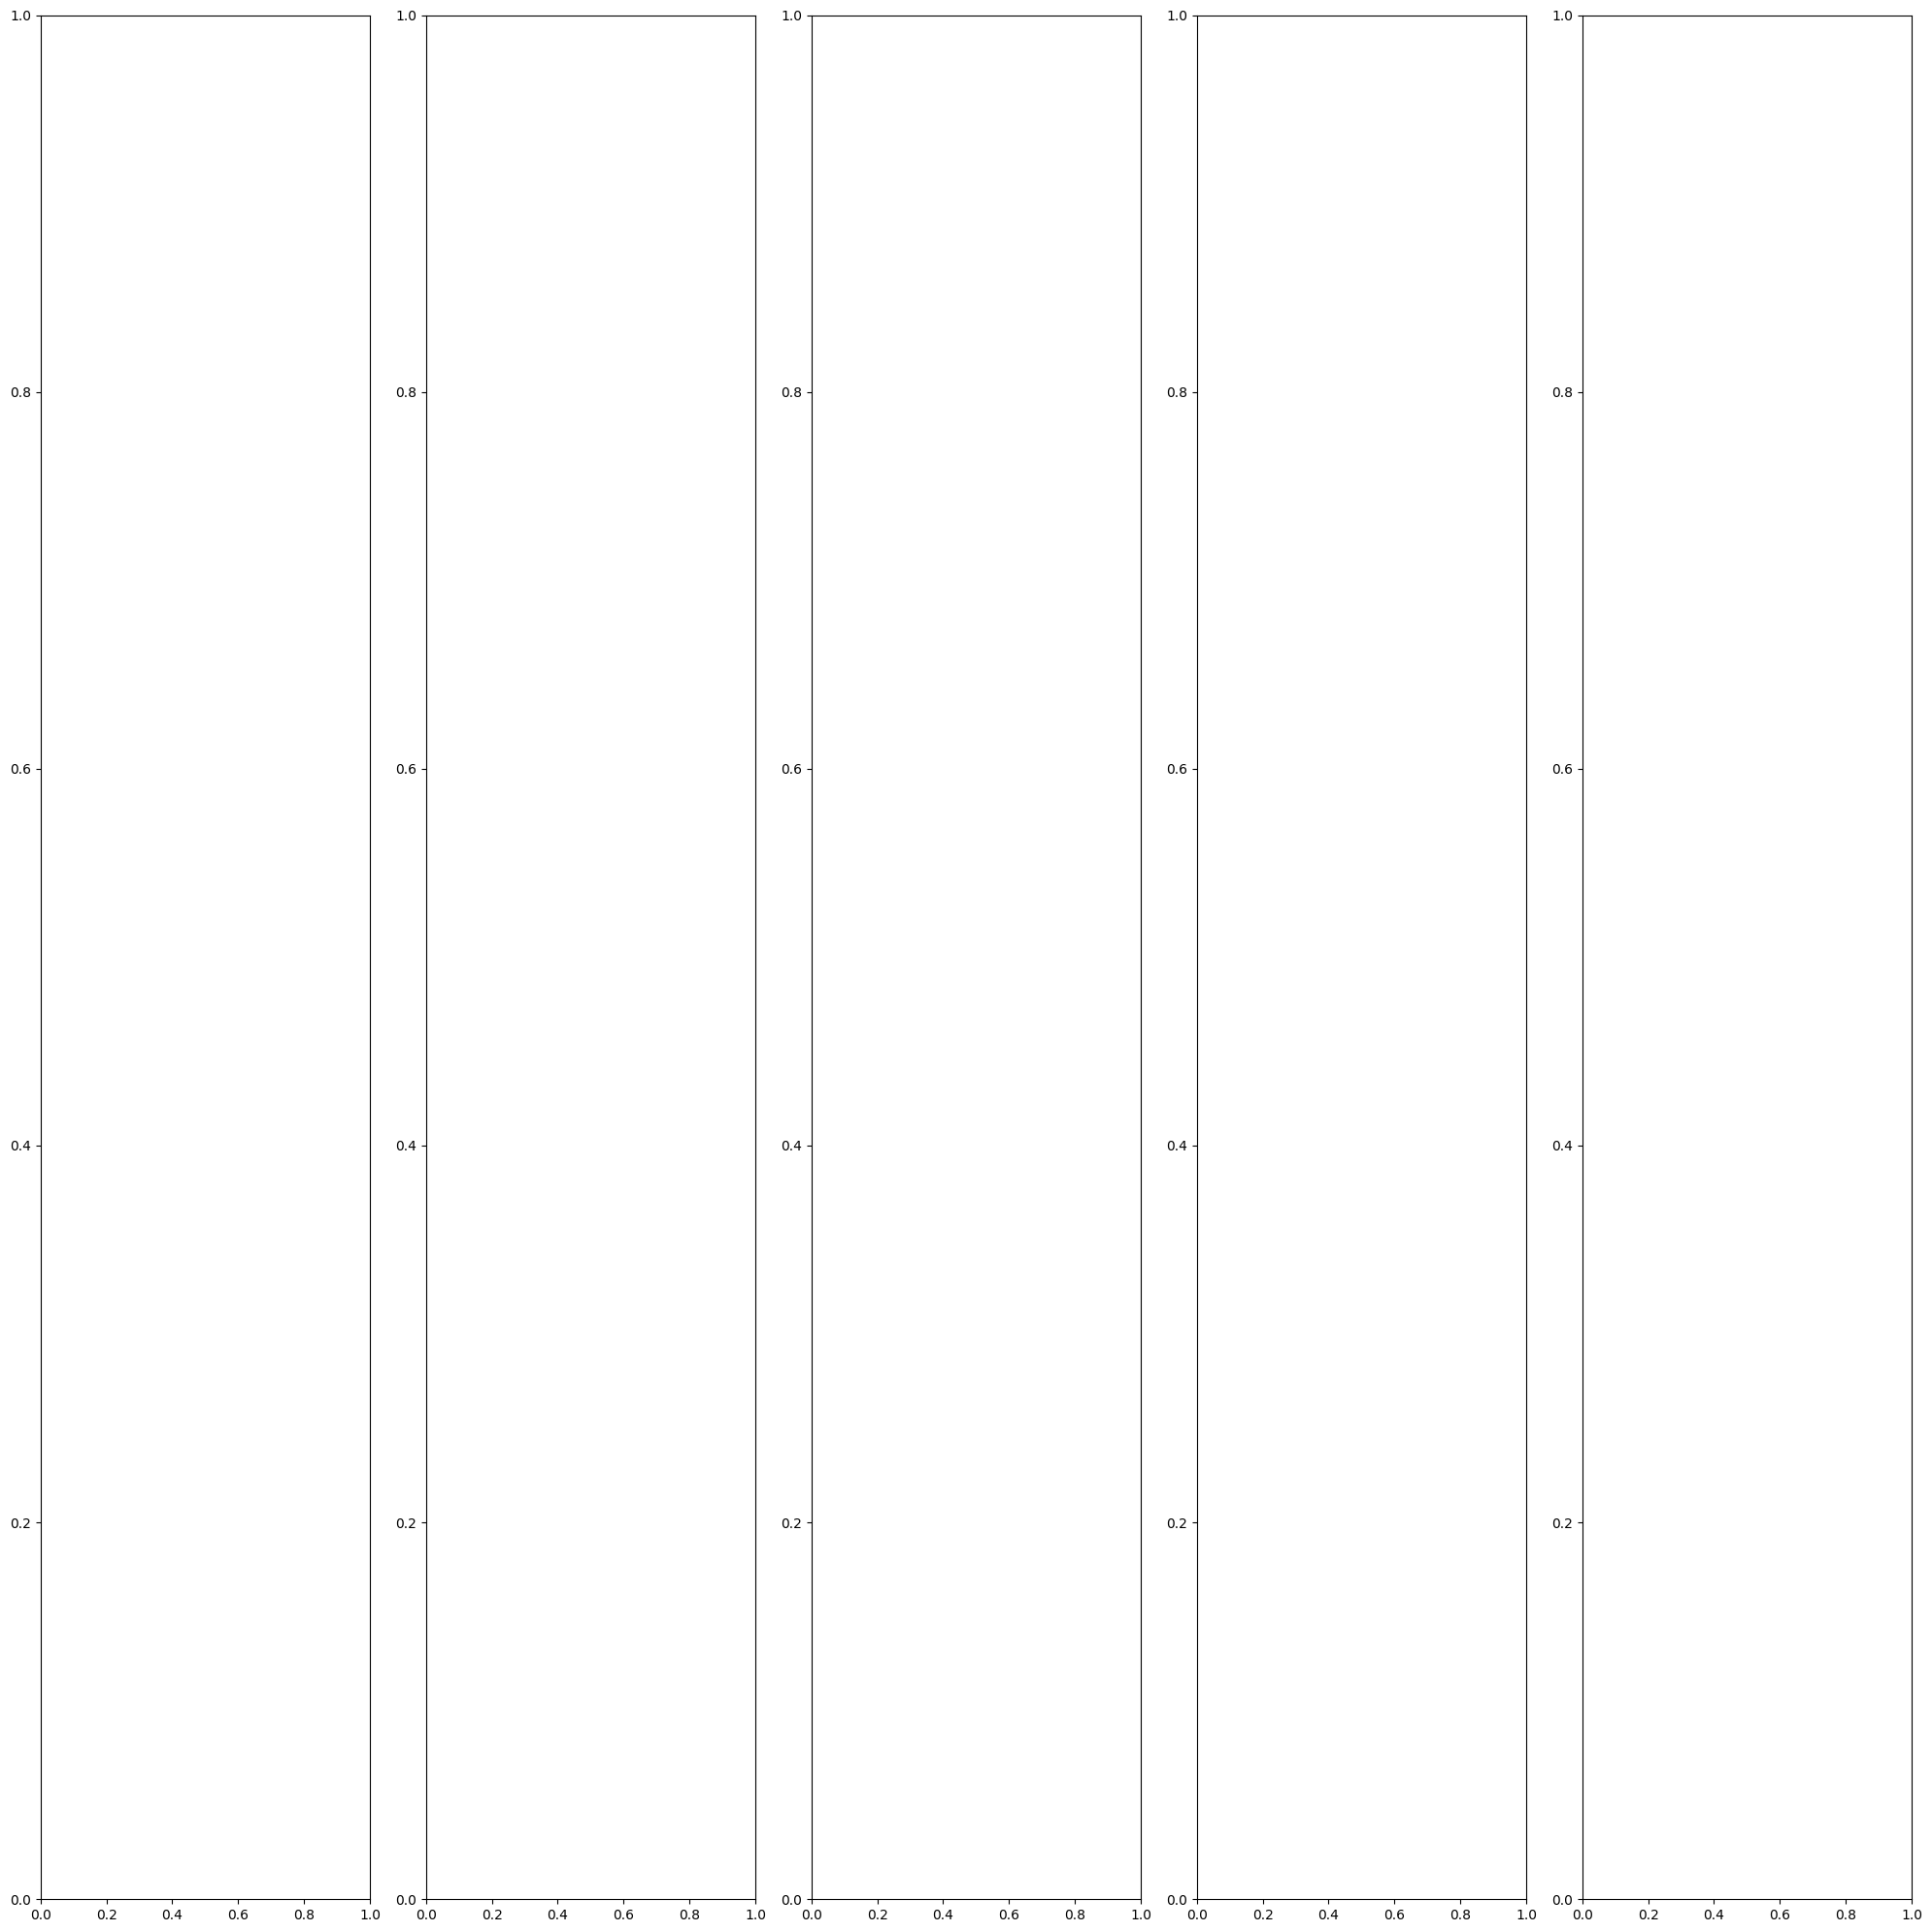

In [9]:
# Cell 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=40,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True,
                                           fill_mode='nearest')

# Cell 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory='cats_and_dogs/train',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

In [10]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=int(np.ceil(valid_data_gen.n / float(batch_size)))
)


model.summary()

Epoch 1/10
63/63 [==============================] - 25s 369ms/step - loss: 0.6994 - accuracy: 0.5135 - val_loss: 0.6880 - val_accuracy: 0.5180
Epoch 2/10
63/63 [==============================] - 23s 366ms/step - loss: 0.6882 - accuracy: 0.5330 - val_loss: 0.6664 - val_accuracy: 0.5690
Epoch 3/10
63/63 [==============================] - 24s 384ms/step - loss: 0.6693 - accuracy: 0.5690 - val_loss: 0.6583 - val_accuracy: 0.5150
Epoch 4/10
63/63 [==============================] - 25s 389ms/step - loss: 0.6609 - accuracy: 0.5875 - val_loss: 0.6593 - val_accuracy: 0.5620
Epoch 5/10
63/63 [==============================] - 24s 383ms/step - loss: 0.6531 - accuracy: 0.6065 - val_loss: 0.6835 - val_accuracy: 0.5480
Epoch 6/10
63/63 [==============================] - 26s 404ms/step - loss: 0.6599 - accuracy: 0.5785 - val_loss: 0.6416 - val_accuracy: 0.6110
Epoch 7/10
63/63 [==============================] - 25s 392ms/step - loss: 0.6370 - accuracy: 0.6280 - val_loss: 0.6050 - val_accuracy: 0.6890

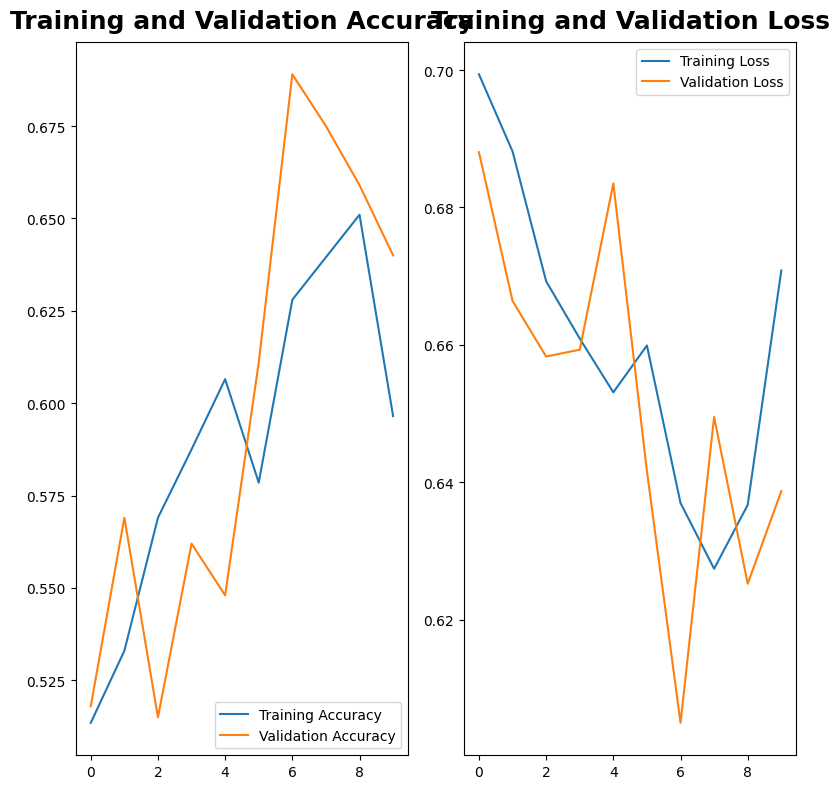

In [11]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 [==============================] - 0s 52ms/step


TypeError: Invalid shape (32, 150, 150, 3) for image data

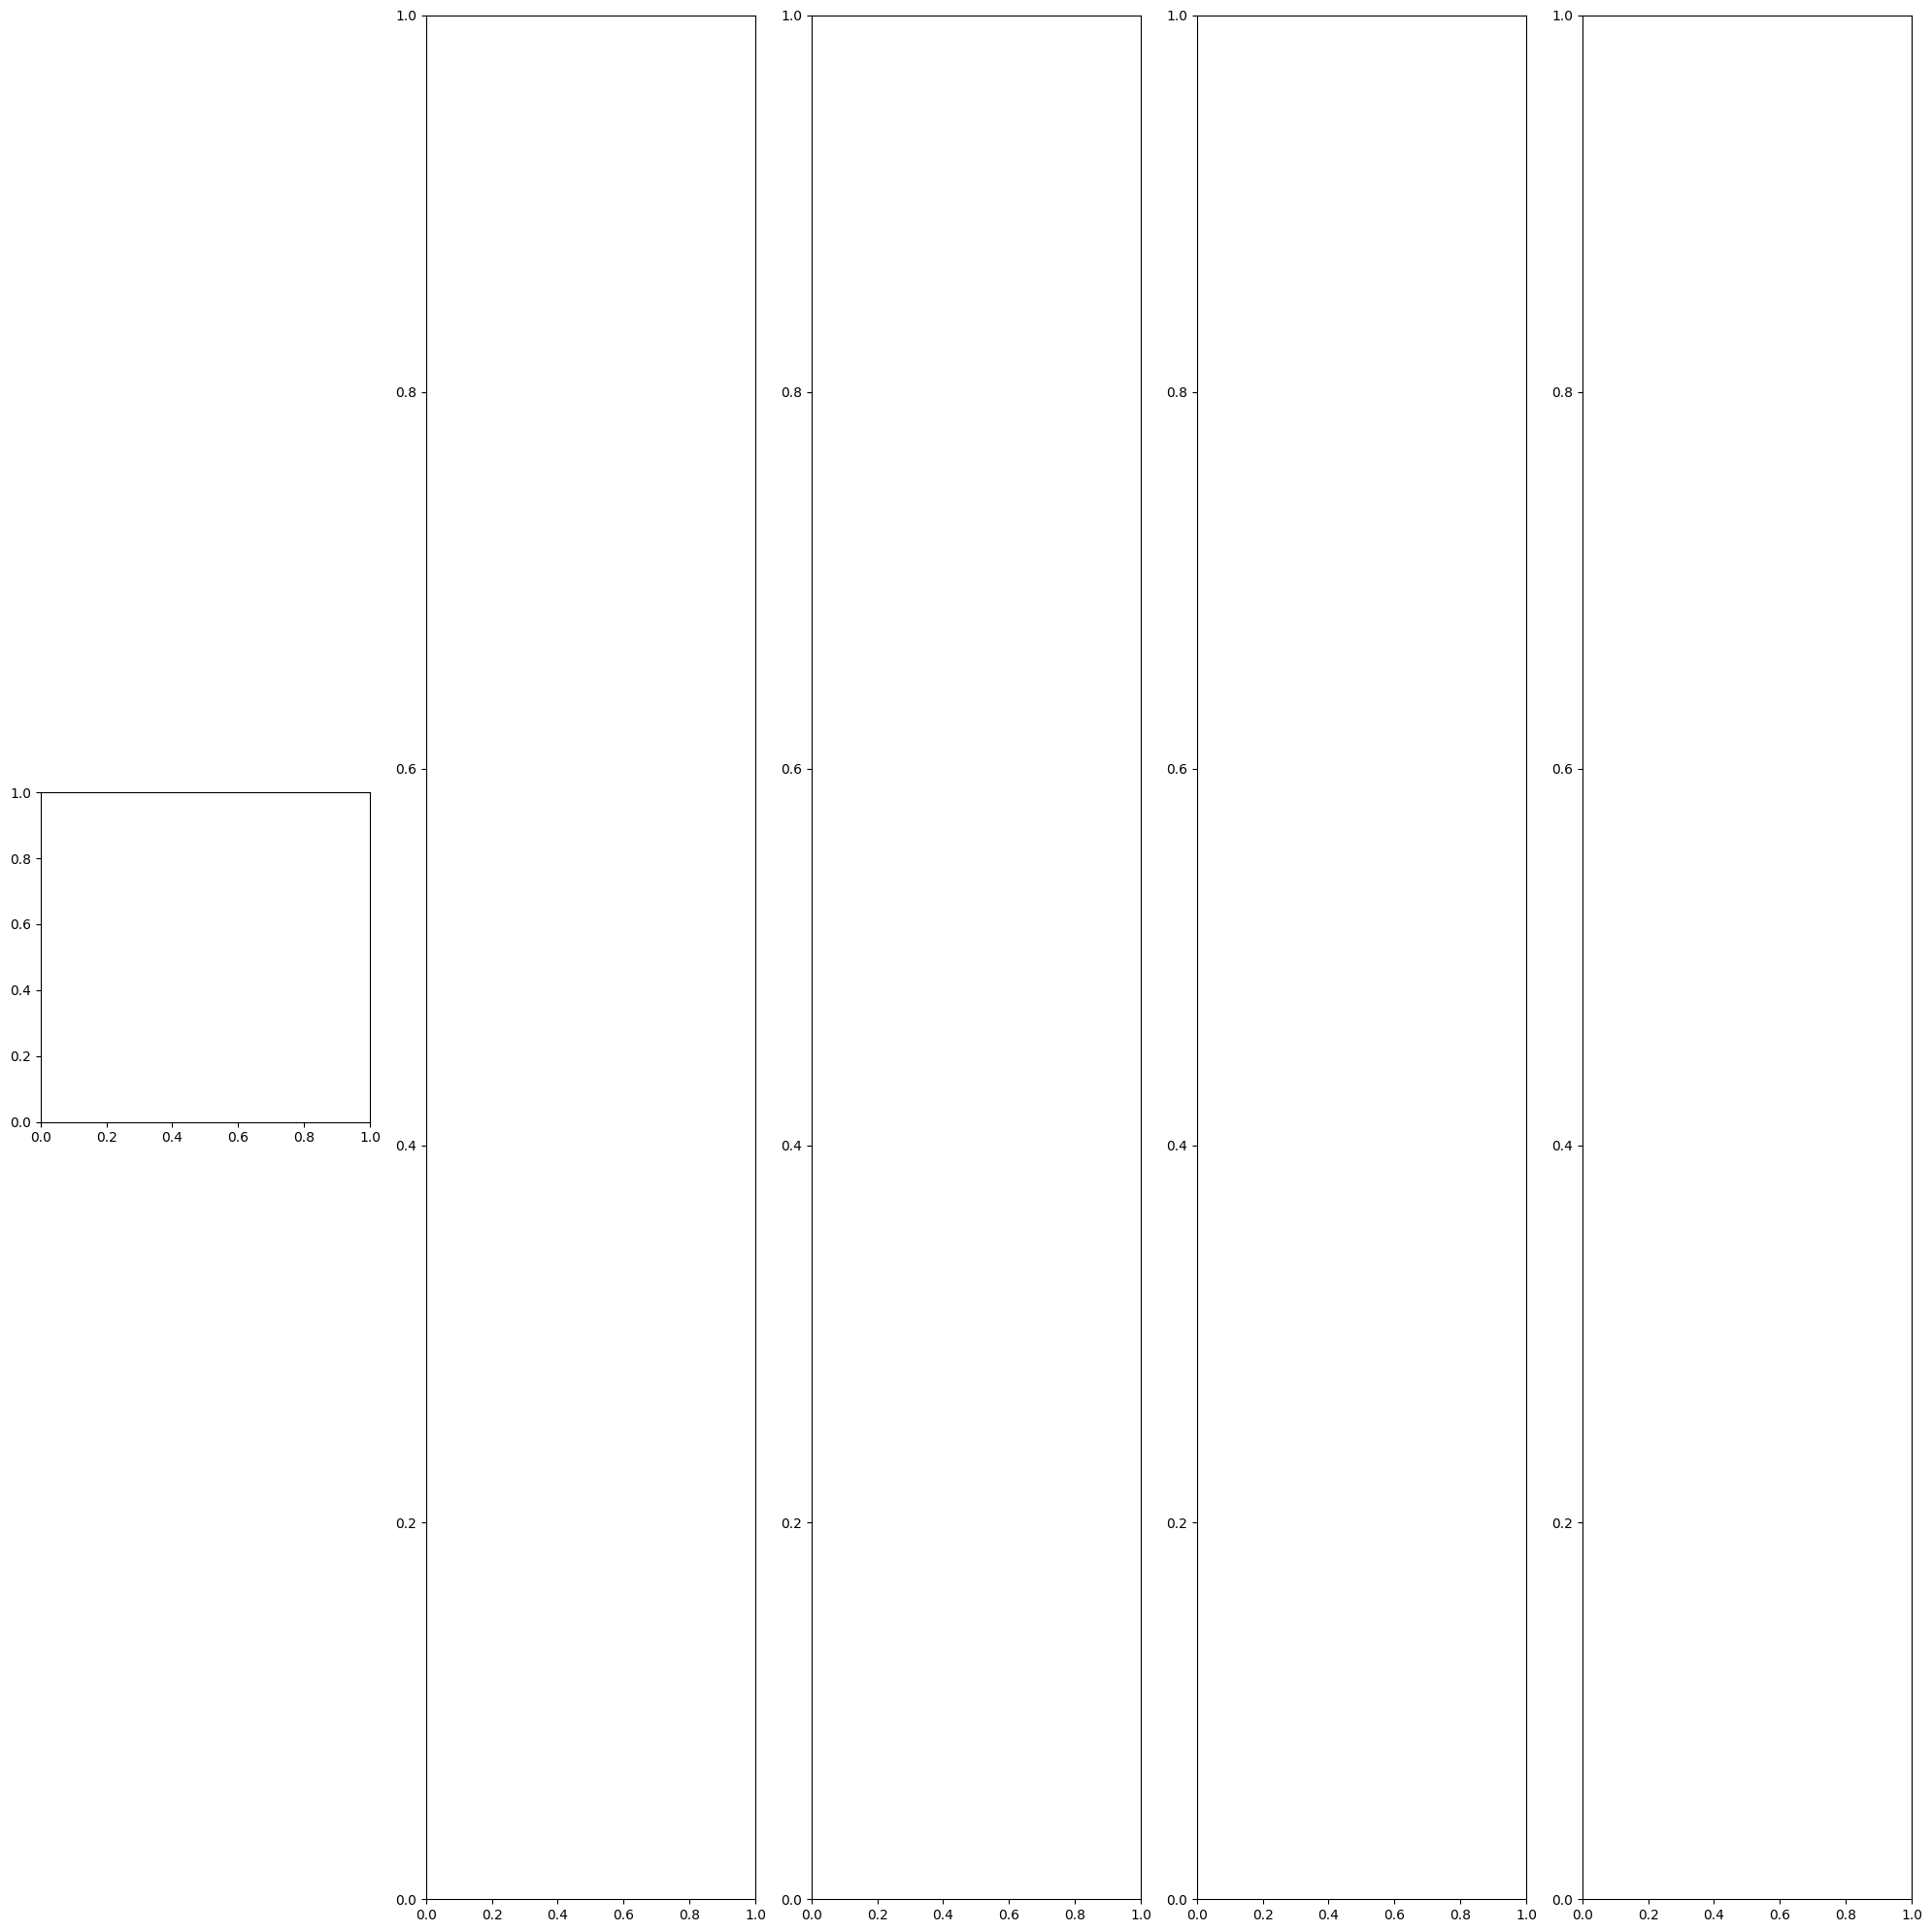

In [11]:
predictions = model.predict(test_data_gen)
probabilities = [pred[0] for pred in predictions]
plot_images(test_data_gen, probabilities)

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0
#test 

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")